In [1]:
# Cell1: Load high-dimensional ResNet features for supervised UMAP
import numpy as np
import umap
import matplotlib.pyplot as plt

OUTPUT_DIR = r"D:\data mining\appendix"

resnet_features = np.load(f"{OUTPUT_DIR}/resnet_features.npy")
true_labels = np.load(f"{OUTPUT_DIR}/true_labels.npy")

class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#C7CEEA']

print("ResNet features:", resnet_features.shape)
print("True labels:", true_labels.shape)

ResNet features: (2527, 512)
True labels: (2527,)


In [2]:
# Cell2: Train supervised UMAP (uses label information)
supervised_umap = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric='euclidean',
    random_state=42
)

emb_supervised = supervised_umap.fit_transform(resnet_features, y=true_labels)

np.save(f"{OUTPUT_DIR}/umap_supervised.npy", emb_supervised)

print("Supervised UMAP completed.")

C:\Users\倪晗骏\dml_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Supervised UMAP completed.


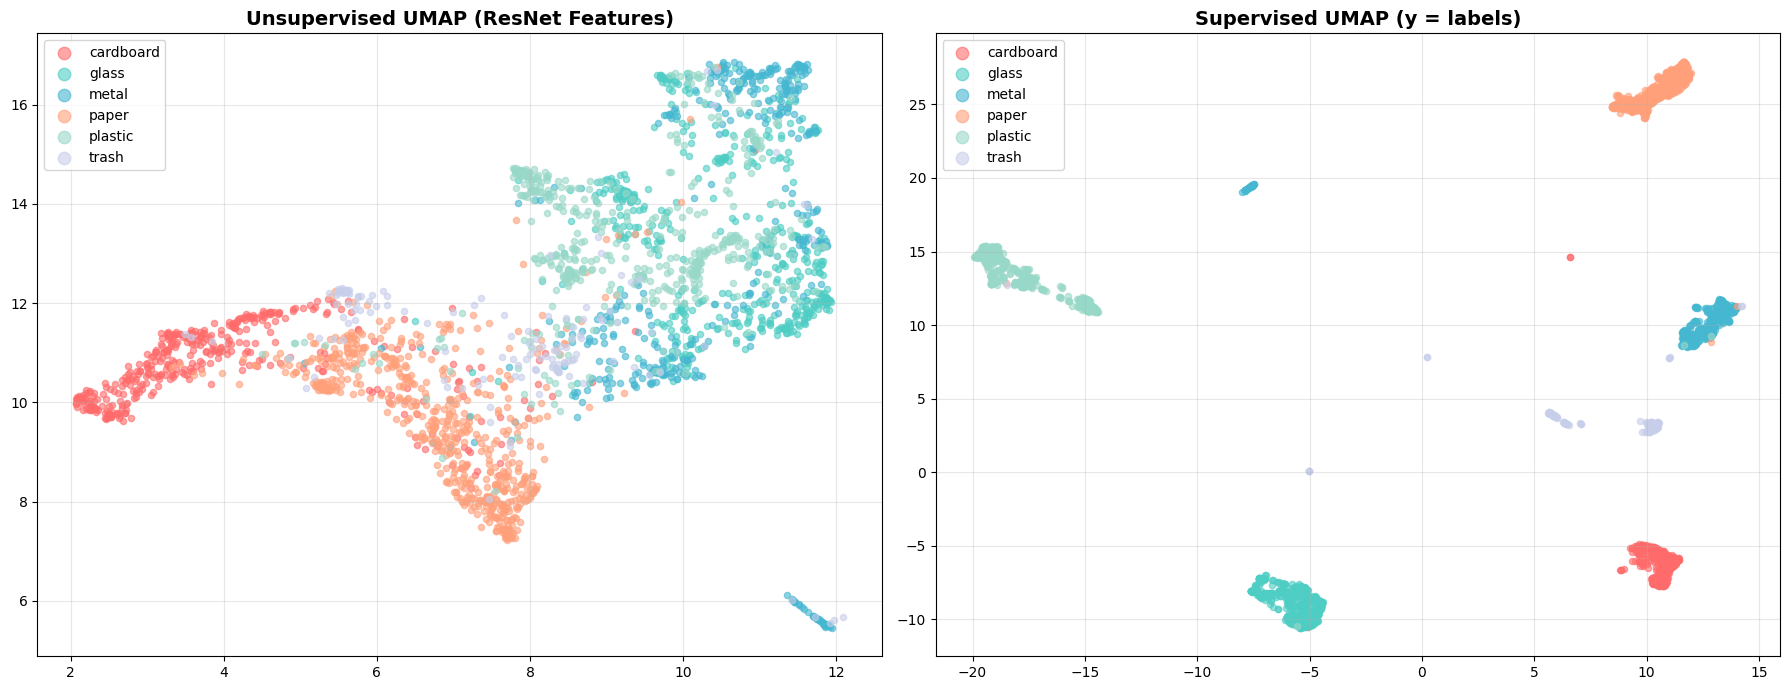

In [3]:
# Cell3: Compare supervised vs unsupervised embeddings

unsupervised = np.load(f"{OUTPUT_DIR}/umap_embeddings.npy")

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

#  Unsupervised UMAP 
for i, (name, color) in enumerate(zip(class_names, colors)):
    mask = (true_labels == i)
    axes[0].scatter(
        unsupervised[mask, 0], unsupervised[mask, 1],
        c=color, s=20, alpha=0.6, label=name
    )

axes[0].set_title("Unsupervised UMAP (ResNet Features)", fontsize=14, fontweight="bold")
axes[0].legend(markerscale=2, fontsize=10)
axes[0].grid(alpha=0.3)

# Supervised UMAP 
for i, (name, color) in enumerate(zip(class_names, colors)):
    mask = (true_labels == i)
    axes[1].scatter(
        emb_supervised[mask, 0], emb_supervised[mask, 1],
        c=color, s=20, alpha=0.6, label=name
    )

axes[1].set_title("Supervised UMAP (y = labels)", fontsize=14, fontweight="bold")
axes[1].legend(markerscale=2, fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/05_supervised_vs_unsupervised_umap.png",
            dpi=300, bbox_inches="tight")
plt.show()

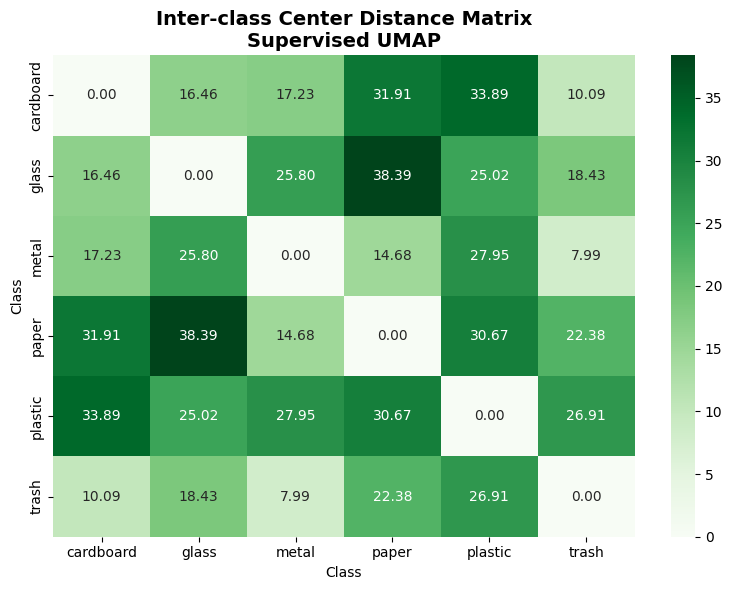

In [4]:
# Cell 4: Compute class-center distances in supervised UMAP
from scipy.spatial.distance import cdist
import seaborn as sns

def class_centers(embeddings, labels):
    centers = []
    for i in np.unique(labels):
        pts = embeddings[labels == i]
        centers.append(pts.mean(axis=0))
    return np.vstack(centers)

sup_centers = class_centers(emb_supervised, true_labels)
supervised_dist = cdist(sup_centers, sup_centers)

plt.figure(figsize=(8, 6))
sns.heatmap(supervised_dist, annot=True, fmt=".2f",
            cmap="Greens", xticklabels=class_names, yticklabels=class_names)
plt.title("Inter-class Center Distance Matrix\nSupervised UMAP", fontsize=14, fontweight="bold")
plt.xlabel("Class")
plt.ylabel("Class")
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/05_supervised_center_distance.png", dpi=300)
plt.show()

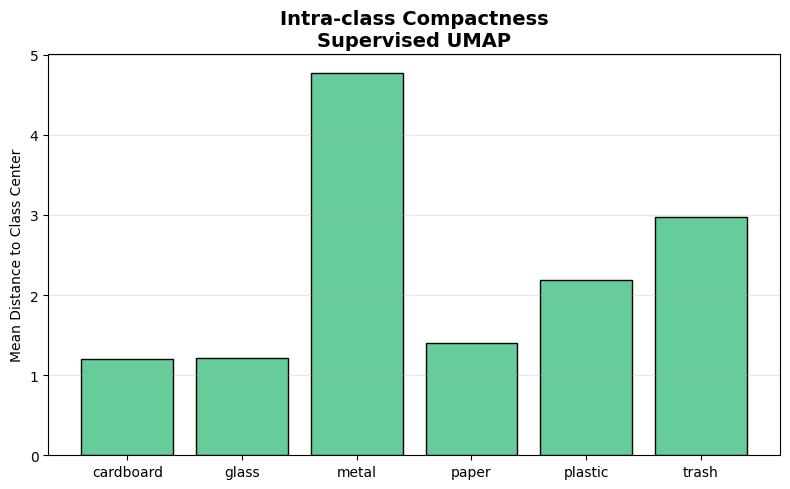

In [5]:
# Cell 5: Intra-class compactness in supervised UMAP

def intra_distances(embeddings, labels):
    intra = []
    for i in np.unique(labels):
        pts = embeddings[labels == i]
        center = pts.mean(axis=0)
        dists = np.linalg.norm(pts - center, axis=1)
        intra.append(dists.mean())
    return np.array(intra)

supervised_intra = intra_distances(emb_supervised, true_labels)

plt.figure(figsize=(8, 5))
plt.bar(class_names, supervised_intra, color="#66CC99", edgecolor="black")
plt.title("Intra-class Compactness\nSupervised UMAP", fontsize=14, fontweight="bold")
plt.ylabel("Mean Distance to Class Center")
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/05_supervised_intra_distance.png", dpi=300)
plt.show()

In [7]:
# Cell 9: Local Overlap Index (LOI) Calculation
from sklearn.neighbors import NearestNeighbors
umap_embeddings = np.load(f'{OUTPUT_DIR}/umap_embeddings.npy')
K = 20  # number of neighbors
nbrs = NearestNeighbors(n_neighbors=K+1).fit(umap_embeddings)
distances, indices = nbrs.kneighbors(umap_embeddings)

# remove itself (first neighbor = itself)
neighbors = indices[:, 1:]

# LOI for each sample = proportion of neighbors with DIFFERENT class
loi = []
for i in range(len(true_labels)):
    yi = true_labels[i]
    neighbor_labels = true_labels[neighbors[i]]
    diff = np.sum(neighbor_labels != yi)
    loi.append(diff / K)

loi = np.array(loi)
np.save(f"{OUTPUT_DIR}/umap_loi.npy", loi)

print("Local Overlap Index computed.")
print("Mean LOI:", loi.mean())

Local Overlap Index computed.
Mean LOI: 0.30565888405223585


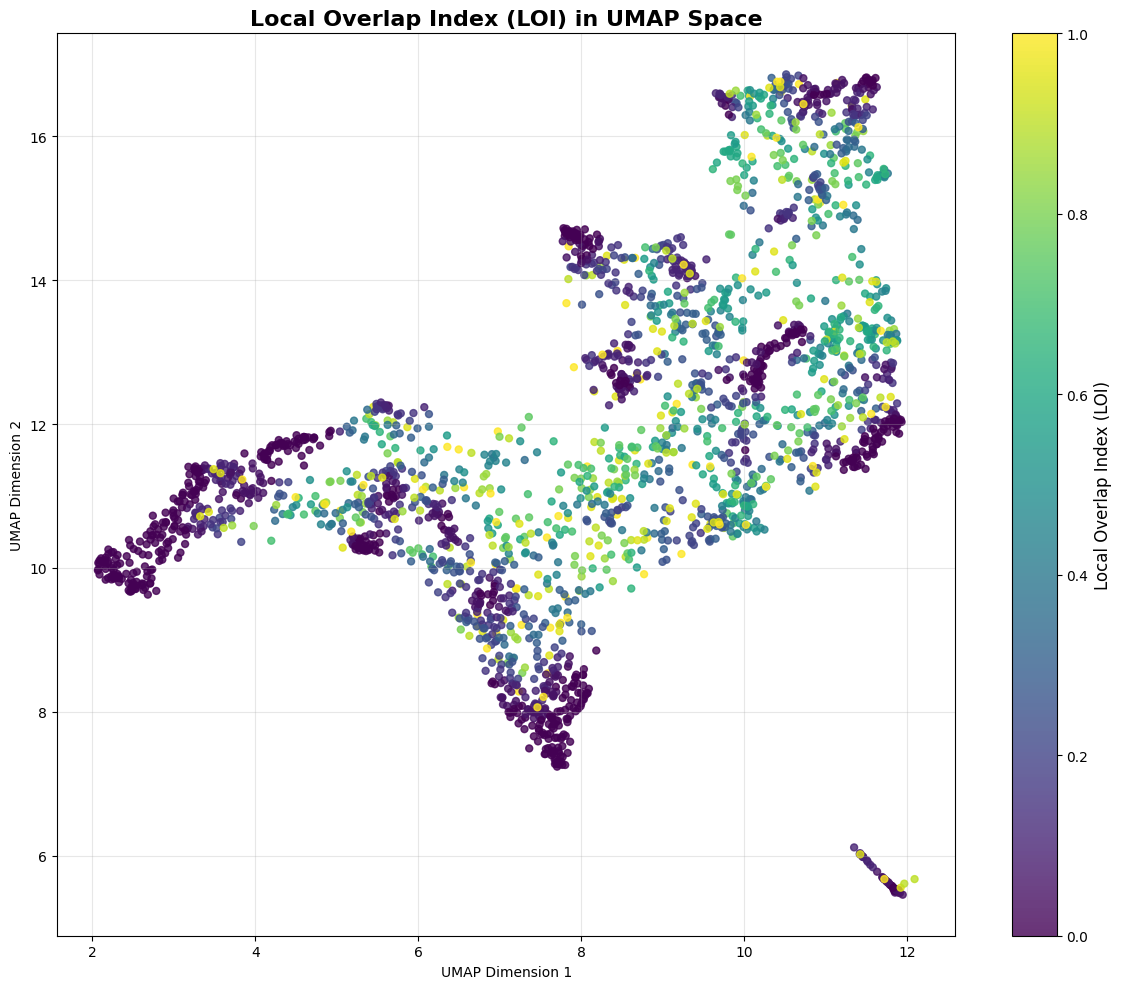

In [8]:
# Cell 10: Scatter plot with LOI coloring

plt.figure(figsize=(12, 10))
plt.scatter(
    umap_embeddings[:, 0],
    umap_embeddings[:, 1],
    c=loi,
    cmap='viridis',
    s=25,
    alpha=0.8
)

cbar = plt.colorbar()
cbar.set_label("Local Overlap Index (LOI)", fontsize=12)

plt.title("Local Overlap Index (LOI) in UMAP Space", fontsize=16, fontweight='bold')
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/04_loi_scatter.png", dpi=300)
plt.show()

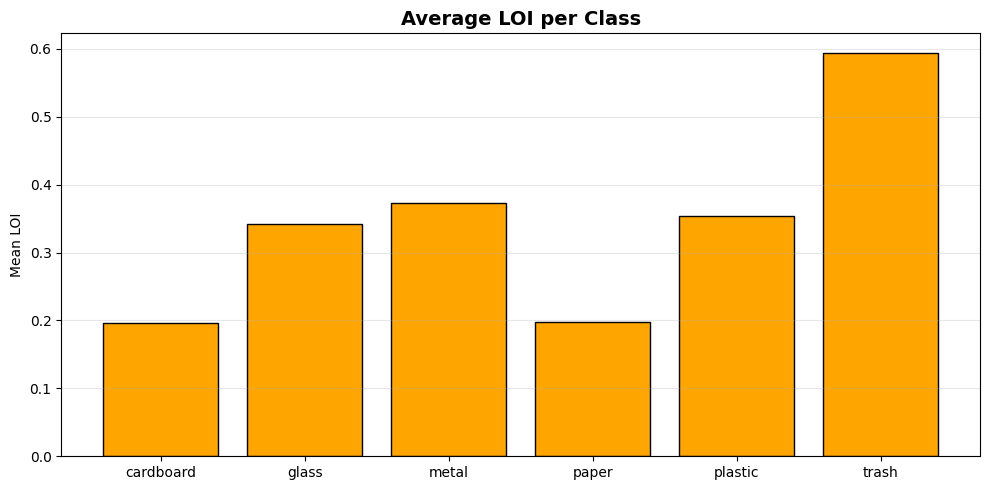

LOI by class:
cardboard: 0.196
glass: 0.342
metal: 0.373
paper: 0.198
plastic: 0.353
trash: 0.593


In [9]:
# Cell 11: LOI by class
class_loi = []

for i, cname in enumerate(class_names):
    class_mask = (true_labels == i)
    class_loi.append(loi[class_mask].mean())

plt.figure(figsize=(10, 5))
plt.bar(class_names, class_loi, color='orange', edgecolor='black')
plt.title("Average LOI per Class", fontsize=14, fontweight='bold')
plt.ylabel("Mean LOI")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/04_loi_per_class.png", dpi=300)
plt.show()

print("LOI by class:")
for cname, value in zip(class_names, class_loi):
    print(f"{cname}: {value:.3f}")

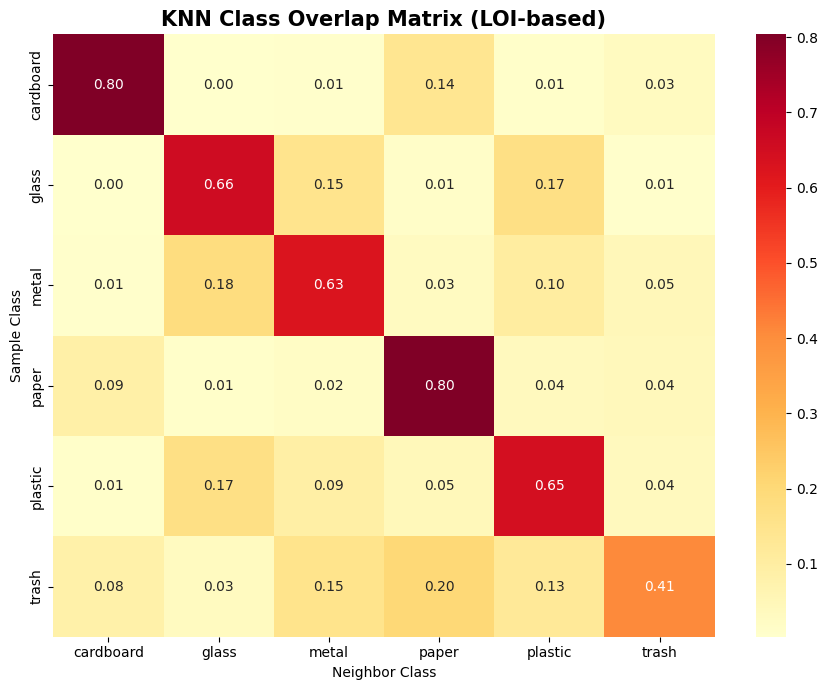

In [10]:
# Cell 12: KNN class-overlap matrix
overlap_matrix = np.zeros((6, 6))

for i in range(len(true_labels)):
    yi = true_labels[i]
    neighbor_labels = true_labels[neighbors[i]]
    for nl in neighbor_labels:
        overlap_matrix[yi, nl] += 1

# Normalize row-wise (proportion)
overlap_matrix = overlap_matrix / overlap_matrix.sum(axis=1, keepdims=True)

plt.figure(figsize=(9, 7))
sns.heatmap(
    overlap_matrix,
    annot=True, fmt=".2f",
    cmap='YlOrRd',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title("KNN Class Overlap Matrix (LOI-based)", fontsize=15, fontweight='bold')
plt.xlabel("Neighbor Class")
plt.ylabel("Sample Class")
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/05_loi_class_overlap.png", dpi=300)
plt.show()

In [11]:
# Cell 13: LOI for Supervised UMAP
emb_sup = np.load(f"{OUTPUT_DIR}/umap_supervised.npy")

nbrs_sup = NearestNeighbors(n_neighbors=K+1).fit(emb_sup)
dist_sup, ind_sup = nbrs_sup.kneighbors(emb_sup)
neighbors_sup = ind_sup[:, 1:]

loi_sup = []
for i in range(len(true_labels)):
    yi = true_labels[i]
    neighbor_labels = true_labels[neighbors_sup[i]]
    diff = np.sum(neighbor_labels != yi)
    loi_sup.append(diff / K)

loi_sup = np.array(loi_sup)

print("Supervised LOI mean:", loi_sup.mean())

Supervised LOI mean: 0.010407597942223982


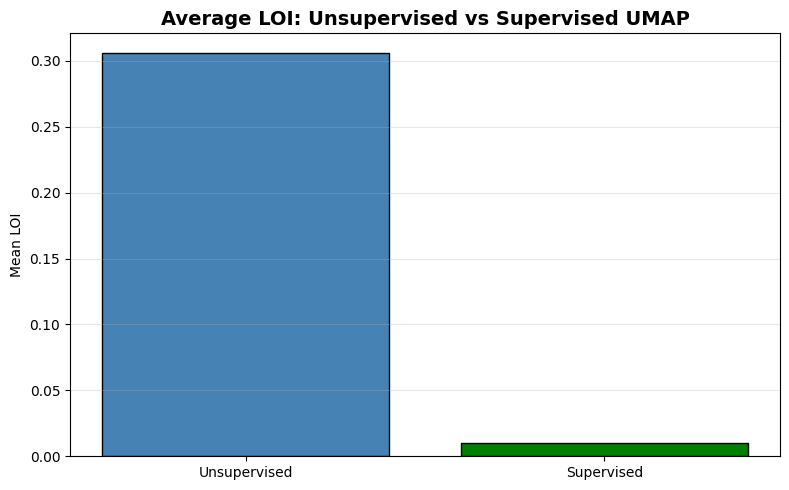

In [12]:
# Cell 14: LOI comparison (Unsupervised vs Supervised)

plt.figure(figsize=(8, 5))
plt.bar(["Unsupervised", "Supervised"], [loi.mean(), loi_sup.mean()],
        color=['steelblue', 'green'], edgecolor='black')

plt.title("Average LOI: Unsupervised vs Supervised UMAP",
          fontsize=14, fontweight='bold')
plt.ylabel("Mean LOI")
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/05_loi_comparison.png", dpi=300)
plt.show()